In [19]:
import re
import random
import pandas as pd
import hashlib

In [20]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
PEP 8,189.909201,6.548593,29
Taxes,320.152690,32.015269,10
WSL + Kali Linux,321.011722,9.441521,34
"CDK Global Ransomeware, June 2024",396.037772,66.006295,6
Open Source/GitHub,463.130011,20.136087,23
Finance Junk,504.776730,63.097091,8
PP365,821.468539,82.146854,10
sklearn,841.723913,120.246273,7
Powershell,914.838002,43.563714,21
Dataverse Plugins,950.166624,135.738089,7


# Histogram

31755.05


<Axes: >

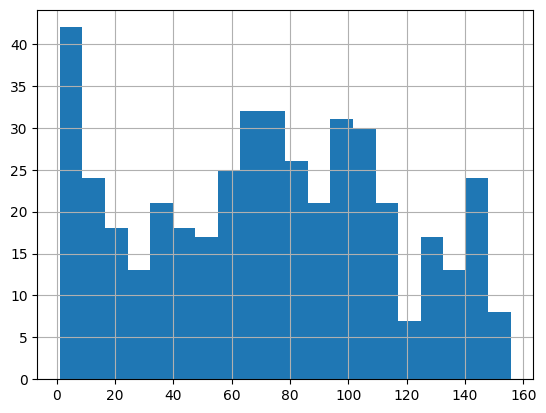

In [22]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [25]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [26]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [27]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [28]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [30]:
n = 8
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 440


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
67,Email Auth and Security,HELO/EHLO\n\nSMTP commands used by a mail serv...,dff0749374b2467bb430e0743e569254,-105.098931,75.683486,105.098931,1665.036694,0.069760,0,0
68,Email Auth and Security,Forwarding Services\n\nThird-party services th...,bc4f5db7cd11c6d0afccfc6b5b2874de,-91.263513,75.683486,105.098931,1665.036694,0.069760,1,0
69,Email Auth and Security,Forensic Reports (Failure Reports)\n\nDetailed...,27474d5d9c77ede5c0d8fa615eac6fd9,-90.857849,75.683486,105.098931,1665.036694,0.069760,2,0
70,Email Auth and Security,Email Spoofing\n\nThe creation of email messag...,1b1e4d69457b3ade027c70cff07839ea,-85.149445,75.683486,105.098931,1665.036694,0.069760,3,0
72,Email Auth and Security,Email Deliverability\n\nThe ability of an emai...,5b4497b514244780055e570fe0681e09,-82.036554,75.683486,105.098931,1665.036694,0.069760,4,0
261,Email Auth and Security,SMTP (Simple Mail Transfer Protocol)\n\nThe st...,6d00c60b39db9ac1eabdc490adf128a4,-81.629450,75.683486,105.098931,1665.036694,0.069760,5,0
71,Email Auth and Security,Identifier Alignment\n\nEnsuring that the doma...,74a89604ca7b2e38b605e5efbb01fe47,-81.079008,75.683486,105.098931,1665.036694,0.069760,6,0
73,Email Auth and Security,p=quarantine\n\nA DMARC policy action.\nInstru...,ef938783fc320a6d315dde8501f4b254,-78.815687,75.683486,105.098931,1665.036694,0.069760,7,0
2,Search Engine Optimization,Google Keyword Planner is a free tool within G...,e82544044c78a5f40db87e202fa454cd,-116.069485,108.324697,116.069485,2166.493947,0.119357,0,0
0,Search Engine Optimization,SEOquake is a browser extension that provides ...,d7914640266665f7eb3726d2cace41c7,-115.570687,108.324697,116.069485,2166.493947,0.119357,1,0


## Age Sum

In [31]:
# n=8
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [32]:
# n=6
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [34]:
existing_cards.head(n)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
67,Email Auth and Security,HELO/EHLO\n\nSMTP commands used by a mail serv...,dff0749374b2467bb430e0743e569254,-105.098931,75.683486,105.098931,1665.036694,0.06976,0,0
68,Email Auth and Security,Forwarding Services\n\nThird-party services th...,bc4f5db7cd11c6d0afccfc6b5b2874de,-91.263513,75.683486,105.098931,1665.036694,0.06976,1,0
69,Email Auth and Security,Forensic Reports (Failure Reports)\n\nDetailed...,27474d5d9c77ede5c0d8fa615eac6fd9,-90.857849,75.683486,105.098931,1665.036694,0.06976,2,0
70,Email Auth and Security,Email Spoofing\n\nThe creation of email messag...,1b1e4d69457b3ade027c70cff07839ea,-85.149445,75.683486,105.098931,1665.036694,0.06976,3,0
72,Email Auth and Security,Email Deliverability\n\nThe ability of an emai...,5b4497b514244780055e570fe0681e09,-82.036554,75.683486,105.098931,1665.036694,0.06976,4,0
261,Email Auth and Security,SMTP (Simple Mail Transfer Protocol)\n\nThe st...,6d00c60b39db9ac1eabdc490adf128a4,-81.629450,75.683486,105.098931,1665.036694,0.06976,5,0
71,Email Auth and Security,Identifier Alignment\n\nEnsuring that the doma...,74a89604ca7b2e38b605e5efbb01fe47,-81.079008,75.683486,105.098931,1665.036694,0.06976,6,0
73,Email Auth and Security,p=quarantine\n\nA DMARC policy action.\nInstru...,ef938783fc320a6d315dde8501f4b254,-78.815687,75.683486,105.098931,1665.036694,0.06976,7,0


In [35]:
existing_cards.head(10)['age'].sum()

np.float64(-927.5706089687039)